In [ ]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
eps = 0.007 #perturbation
use_cuda = torch.cuda.is_available()
use_cuda

False

In [ ]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("/content/drive/MyDrive/adversarial/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [ ]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [ ]:
normal_data = image_folder_custom_label(root = '/content/drive/MyDrive/adversarial/', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [ ]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


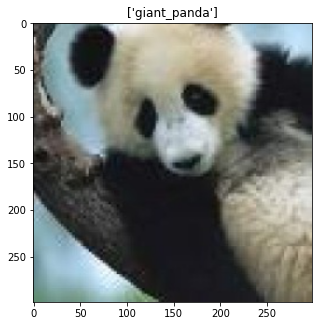

In [ ]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [ ]:
model = models.inception_v3(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

True Image & Predicted Label


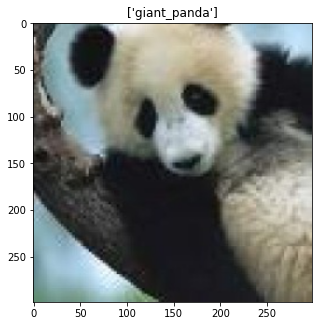

Accuracy of test text: 100.000000 %


In [ ]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for image, labels in normal_loader:
    
    image = image.to(device)
    labels = labels.to(device)
    outputs = model(image)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(image.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

In [ ]:
def fgsm_attack(model, loss, images, labels, eps):
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()

    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign() #FGSM Formula

    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [ ]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


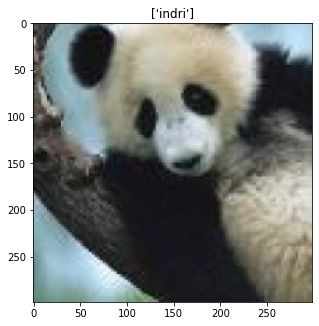

Accuracy of test text: 0.000000 %


In [ ]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for image, labels in normal_loader:
    
    image = fgsm_attack(model, loss, image, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(image)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(image.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))